In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import math

from functools import reduce

spm = pd.read_csv('SPM/SPM_results.csv', sep=',')
scc_col = pd.read_csv('SCC/SCC_COL_results.csv', sep=',')
scc_fb = pd.read_csv('SCC/SCC_FB_results.csv', sep=',')
sorting = pd.read_csv('sorting/sorting_results.csv', sep=',')
prefix_sum = pd.read_csv('prefix_sum/prefix_sum_results.csv', sep=',')
synthesis = pd.read_csv('synthesis/synthesis_results.csv', sep=',')

all_data = [spm, scc_col, scc_fb, sorting, prefix_sum, synthesis];
cols = list(map((lambda d : d.columns), all_data));
assert (all([all(cols[i-1] == cols[i]) for i in range(1, len(cols))]));

data = pd.concat(all_data, ignore_index=True);



In [47]:
data = data.drop(data[data["runtime"] == "timeout"].index);
data["runtime"] = data["runtime"].astype(float);
data["problem_size"] = data["problem_size"].astype(int);
data["weak_non_racing"] = data["weak_non_racing"].astype(bool);

print(math.log10(data["problem_size"].min()));
print(math.log10(data["problem_size"].max()));

data[data["algorithm"] == "prefix_sum"]

2.8312296938670634
7.861670783003025


,memorder,schedule,voting-strat,weak_non_racing,algorithm,problem_type,problem_size,runtime
770,seqcons,graph,graph-simple,True,prefix_sum,Random,10000,0.135539
771,seqcons,graph,graph-simple,True,prefix_sum,Random,55000,0.175568
772,seqcons,graph,graph-simple,True,prefix_sum,Random,100000,0.245446
773,seqcons,graph,graph-simple,True,prefix_sum,Random,550000,1.585734
774,seqcons,graph,graph-simple,True,prefix_sum,Random,1000000,2.660125
775,seqcons,graph,graph-simple,True,prefix_sum,Random,5500000,15.978041
776,seqcons,graph,graph-simple,True,prefix_sum,Random,10000000,29.371350


In [ ]:
print(math.log10(data["problem_size"].min()));
""" Returns all rows with a configuration that is present
    for all possible values of variable_parameter, such that
    the only configuration-related difference between rows 
    is the variable_parameter.
"""
def get_comparable_rows(all_rows, rows, variable_parameter):
    # Group rows by config, except for the variable_parameter
    config_cols = [
        "memorder",
        "schedule",
        "voting-strat",
        "weak_non_racing",
        "algorithm",
        "problem_type",
        "problem_size"
    ];
    config_cols.remove(variable_parameter);
    
    # Compute all available variable_parameter options
    p_options = all_rows[variable_parameter].unique();
    
    # Per possible value of variable_parameter, get the corresponding rows
    rows_per_option = [rows[rows[variable_parameter] == opt] for opt in p_options];
    
    # Find the unique configs present per value of variable_parameter
    sets_of_configs = [set(r.groupby(config_cols).groups.keys()) for r in rows_per_option];
    
    # Get configs which are present for all possible values of variable_parameter
    shared_configs = list(reduce((lambda x, y : x & y), sets_of_configs));
    
    # Return all rows which have a shared config
    by_config = rows.groupby(config_cols);
    comp_rows = [];
    for (c, c_rows) in by_config:
        if c in shared_configs:
            comp_rows.append(c_rows);
    if comp_rows == []:
        print("WARNING: EMPTY ROWS TO COMPARE");
        return pd.DataFrame(data={});
    comparable_rows = pd.concat(comp_rows);
        
    return comparable_rows;


In [ ]:
def bar_chart(all_rows, rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = all_rows[variable_parameter].unique();
    assert (len(ordering) == len(all_rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(all_rows, rows, variable_parameter);
    tot_width = 0.8;
    width = tot_width / len(ordering);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    ys = [];
    p_sizes = list(rows["problem_size"].unique());
    p_sizes.sort();
    nrof_values = len(p_sizes);
    
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        Y = rows.groupby("problem_size")["runtime"].mean();
        assert(nrof_values == len(Y.values));
        X = [x + offset for x in range(len(Y.values))];
        ys.append(Y);
        plt.bar(X, Y.values, width=width, label=o);
        offset += width;
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.xticks(range(nrof_values), [str(round(p, -3)/1000)+"K" for p in p_sizes]);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();
    return ys;

def scatter_chart(all_rows, rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = all_rows[variable_parameter].unique();
    assert (len(ordering) == len(all_rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(all_rows, rows, variable_parameter);
    cols = ["C0", "C1", "C2", "C3", "C4", "C5"];
    col_idx = 0;
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        for c, rows in rows.groupby("config"):
            plt.plot(rows["problem_size"], rows["runtime"], color=cols[col_idx % len(cols)], label=o);
        col_idx += 1;
    
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    patches = [mpatches.Patch(color=cols[i % len(cols)], label=ordering[i]) for i in range(len(ordering))];
    plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

In [ ]:
def memorder_chart(alg, p_type, data):
    rows = data[(data["algorithm"] == alg) & (data["problem_type"] == p_type)];
    plt.figure();
    plt.title(f"The relative runtime performance impact of memory order\n({alg}: {p_type})");
    order = ["relaxed", "acqrel", "seqcons"];
    
    colors = {
        "relaxed": "C0",
        "acqrel": "C2",
        "seqcons": "C1"
    };
    linestyles = {
        True: "-",
        False: "--"
    };
    markers = {
        "graph": ("P", 7),
        "in-kernel": ("D", 5),
        "on-host": ("*", 8)
    };
    
    config_cols = [
        "schedule",
        "voting-strat",
        "weak_non_racing",
    ];
    for c, c_rows in rows.groupby(config_cols):
        if len(c_rows["memorder"].unique()) != 3:
            print(f"Skipping {c}");
            continue;
        
        o_data = [
            c_rows[c_rows["memorder"] == o]
            [["problem_size", "runtime"]]
            .set_index("problem_size")
            .rename(columns={"runtime": f"runtime_{o}"})
            for o in order
        ];
        ref = pd.concat(o_data, axis=1);
        
        for o in order:
            plt.plot(
                ref.index,
                (ref[f"runtime_{o}"] / ref[f"runtime_relaxed"]) * 100,
                color=colors[o],
                label=f"{o} {c[0]}{' opt' if c[2] else ''}",
                linestyle=linestyles[c[2]],
                marker=markers[c[0]][0] if o != "relaxed" else None,
                markersize=markers[c[0]][1]
            );
            
    plt.xscale("log");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

memorder_chart("synthesis", "Random", data)
memorder_chart("SPM", "Invariantly Inevitably Eat", data)
memorder_chart("SCC_FB", "Random Graph (p=1.3/n)", data)
memorder_chart("SCC_COL", "Random Graph (p=1.3/n)", data)

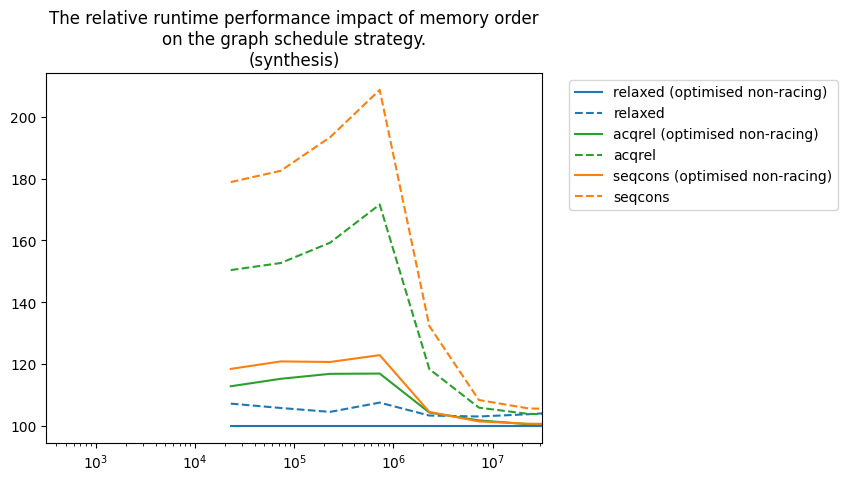

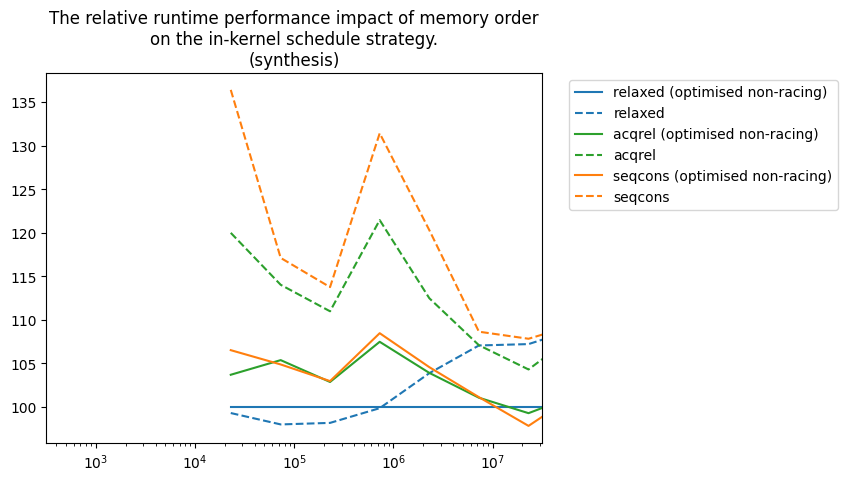

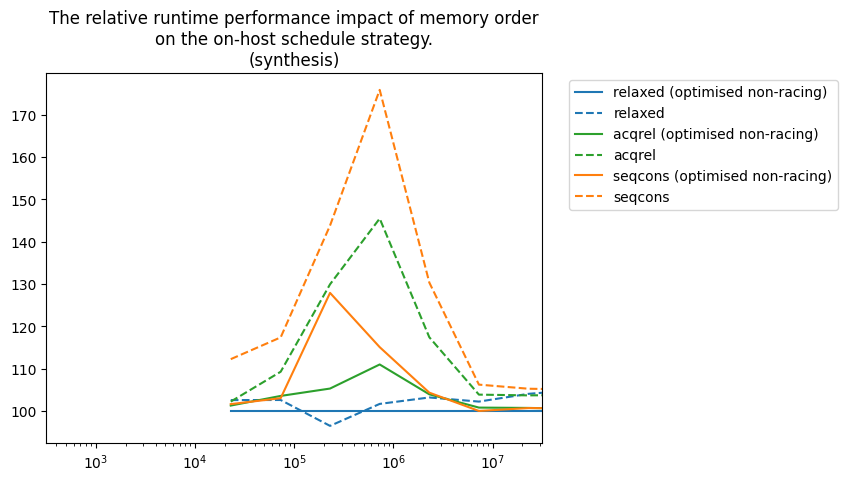

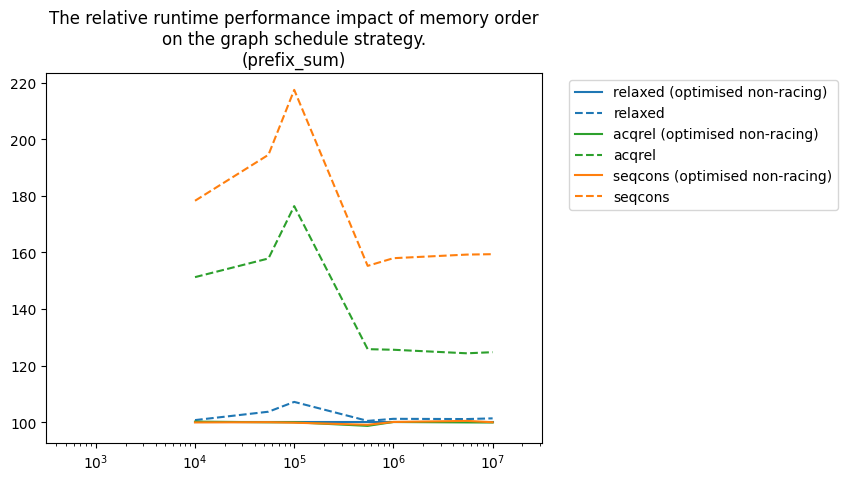

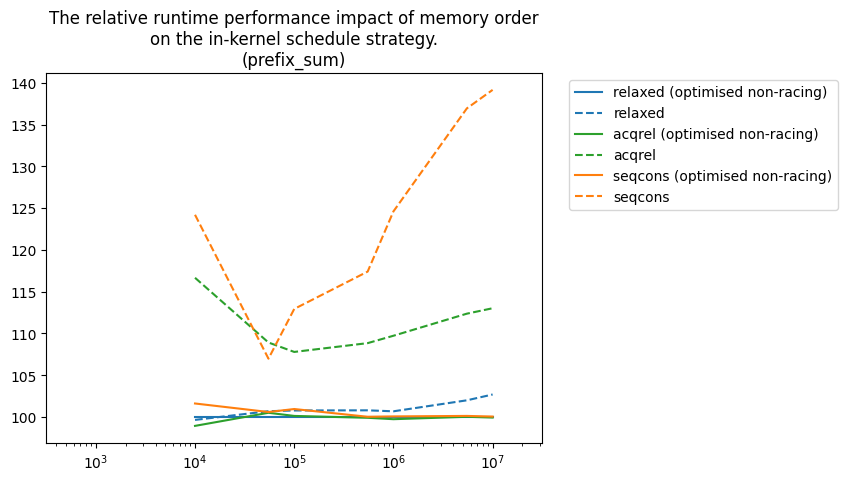

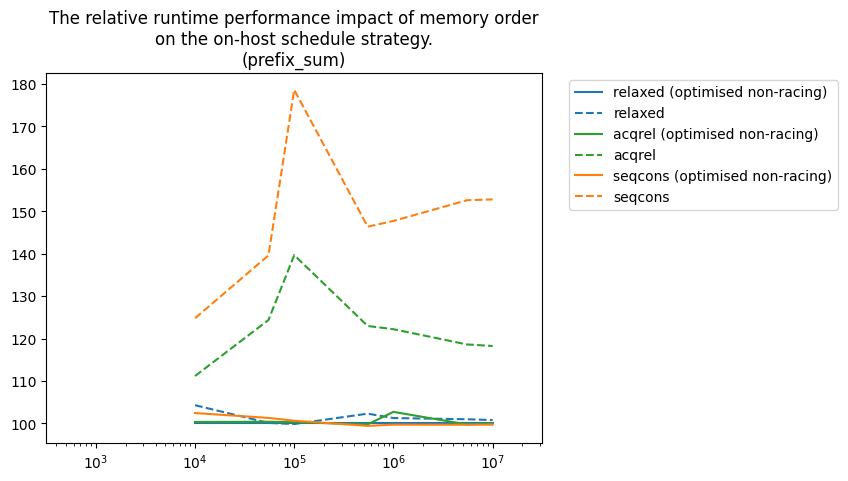

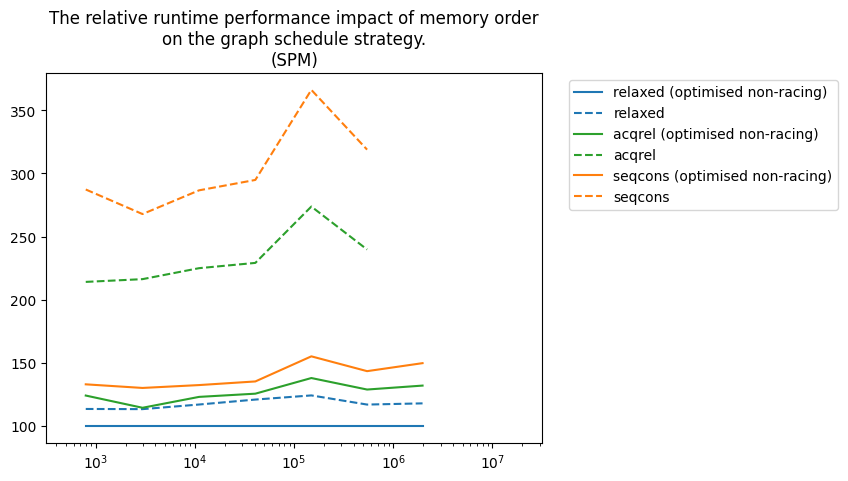

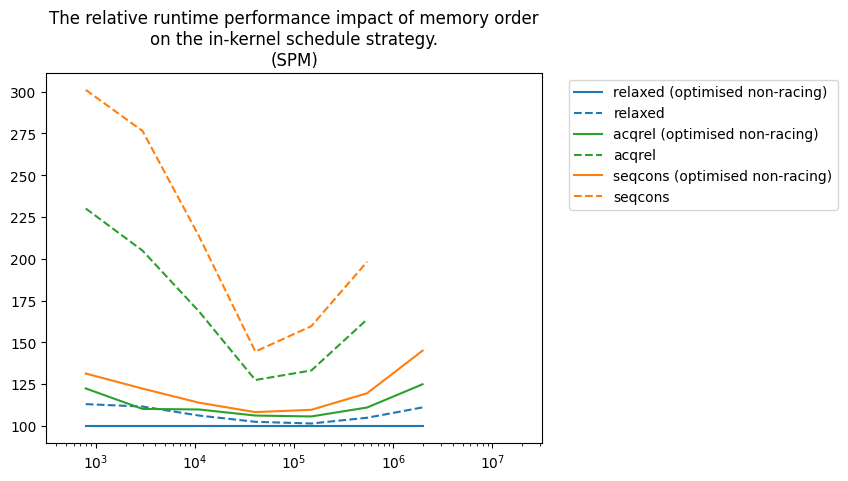

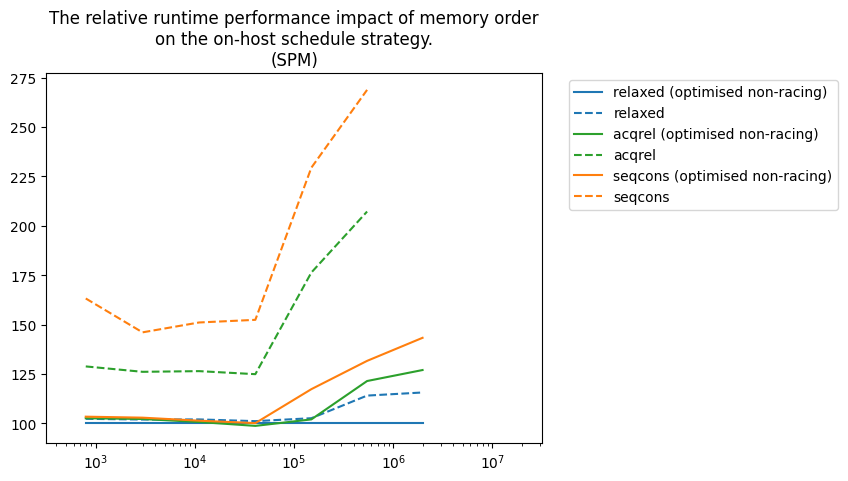

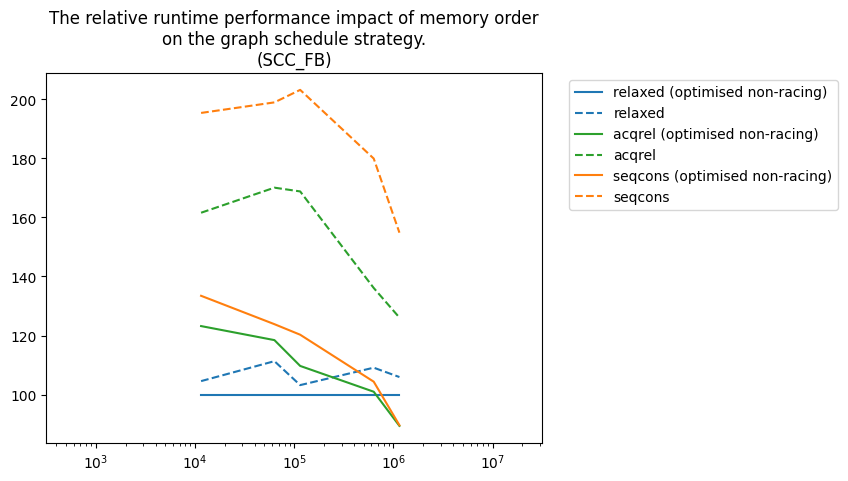

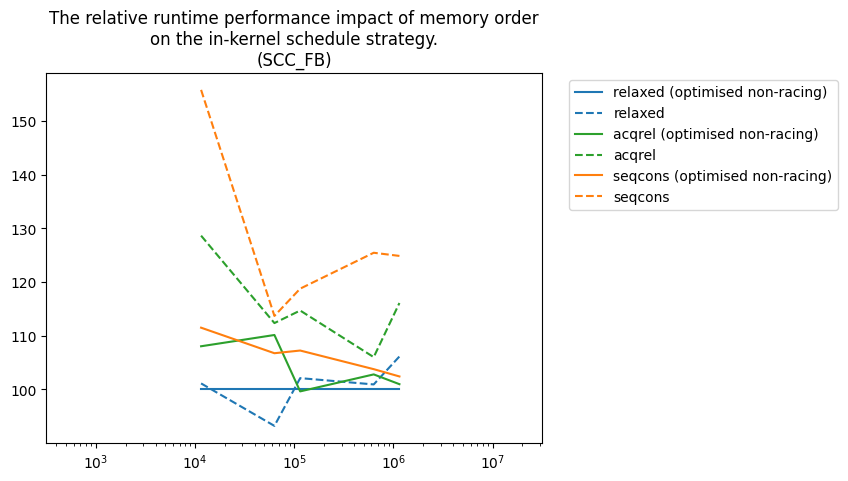

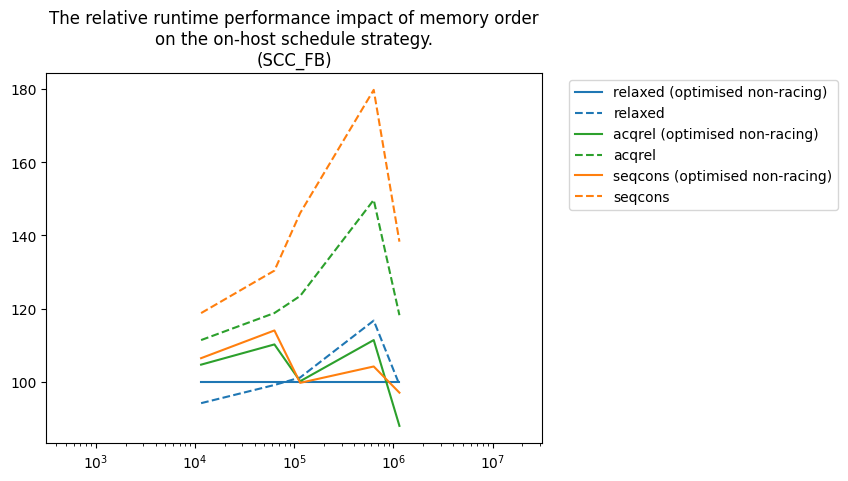

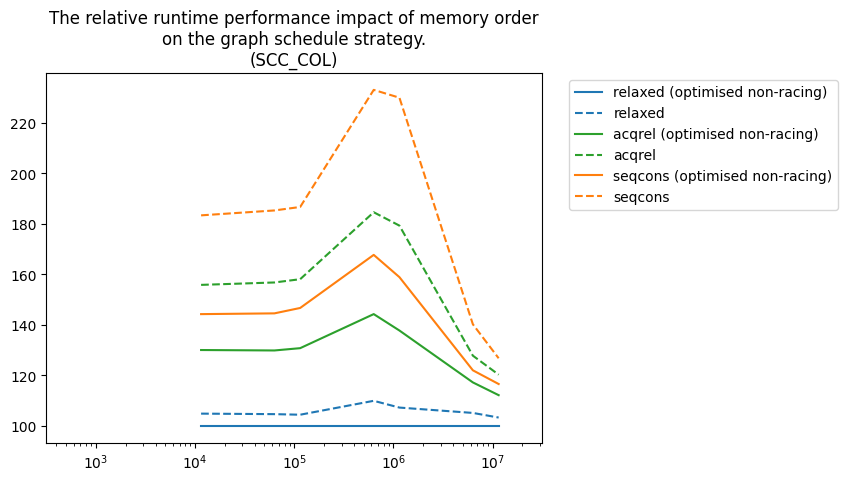

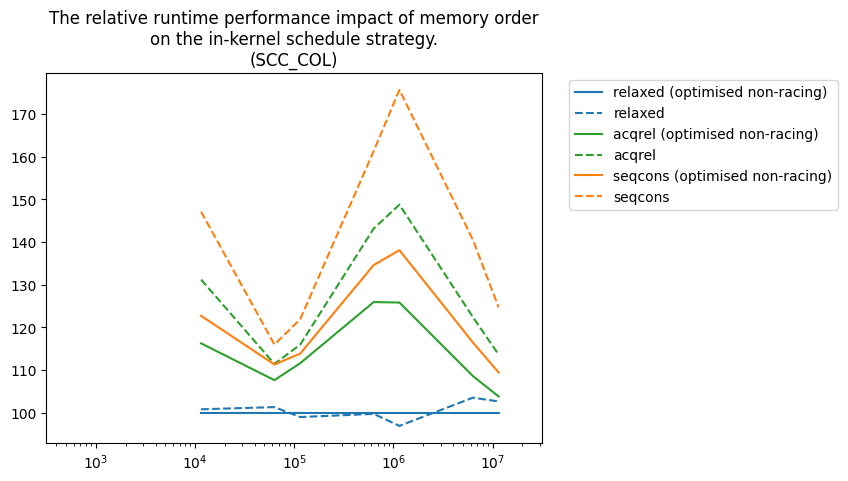

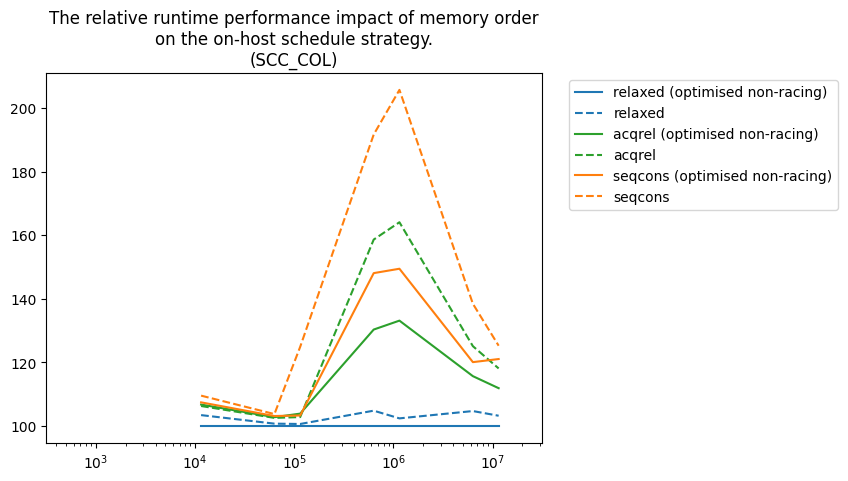

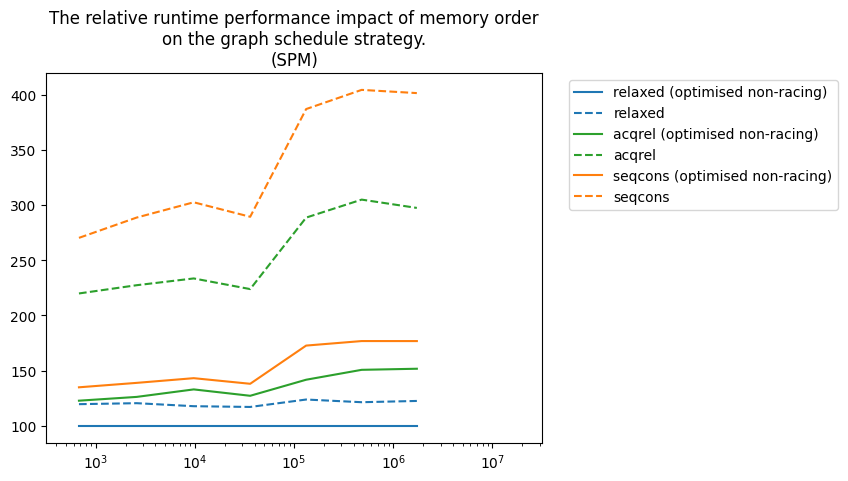

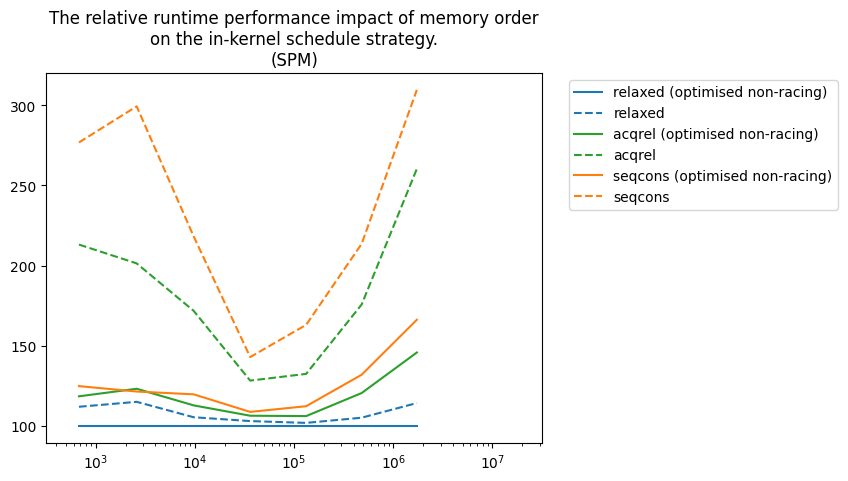

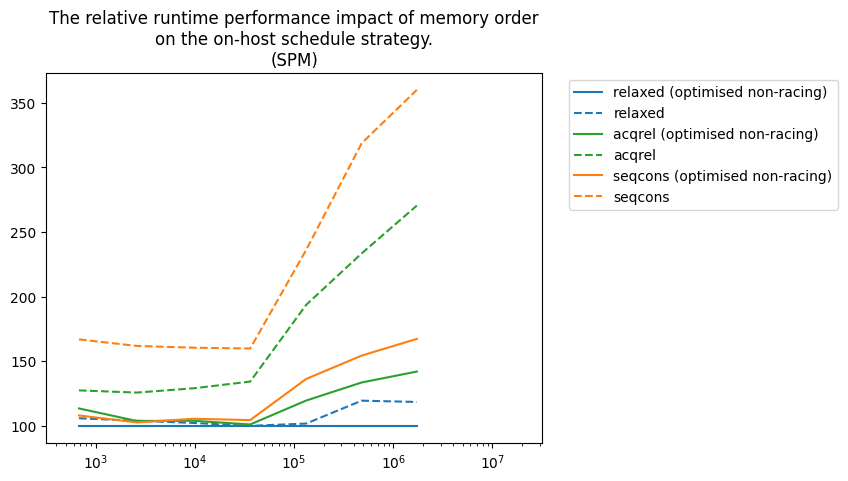

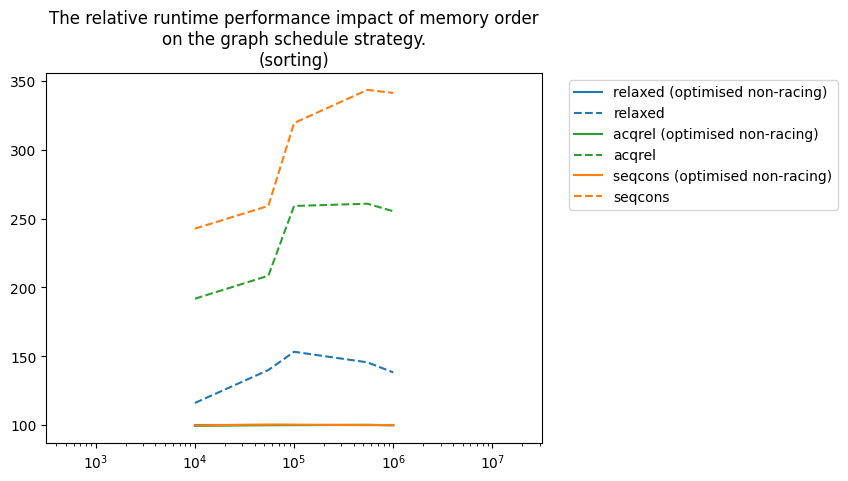

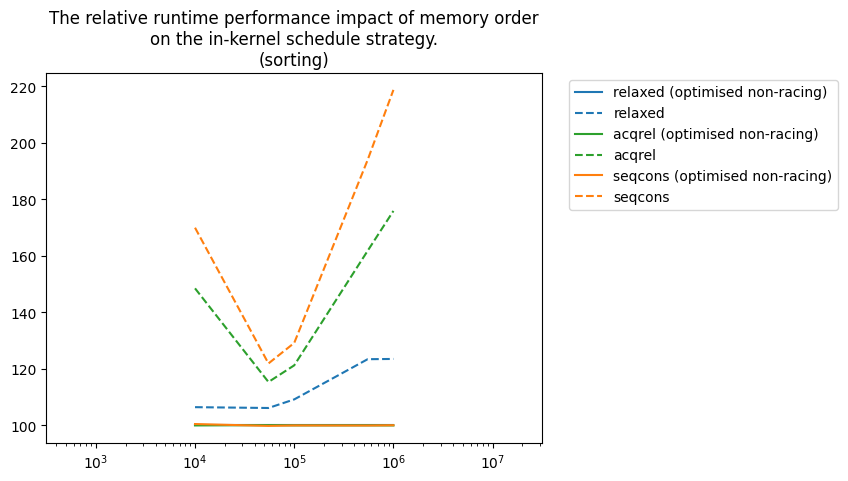

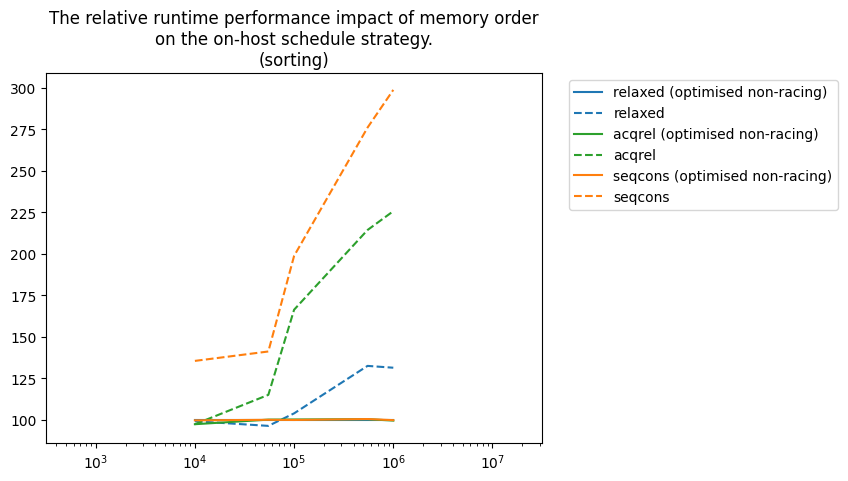

In [43]:
def memorder_chart2(alg, p_type, data):
    rows = data[(data["algorithm"] == alg) & (data["problem_type"] == p_type)];
    order = ["relaxed", "acqrel", "seqcons"];
    
    colors = {
        "relaxed": "C0",
        "acqrel": "C2",
        "seqcons": "C1"
    };
    linestyles = {
        True: "-",
        False: "--"
    };
    markers = {
        "graph": ("P", 7),
        "in-kernel": ("D", 5),
        "on-host": ("*", 8)
    };
    
    config_cols = [
        "schedule",
        "voting-strat"
    ];
    
    for sched, sched_rows in rows.groupby("schedule"):
        plt.figure()
        plt.title(("The relative runtime performance impact of memory order\n"
                   f"on the {sched} schedule strategy.\n"
                   f"({alg})"
                 ));
        for c, c_rows in sched_rows.groupby(config_cols):
            if len(c_rows["memorder"].unique()) != 3:
                #print(f"Skipping {c}");
                continue;
            
            o_data = pd.concat([
                c_rows[(c_rows["memorder"] == o) & (c_rows["weak_non_racing"] == w)]
                [["problem_size", "runtime"]]
                .set_index("problem_size")
                .rename(columns={"runtime": f"runtime_{o}{'_opt' if w else ''}"})
                for o in order
                for w in [True, False]
            ], axis = 1);
            
            for o in order:
                for w in [True, False]:
                    Y = (o_data[f"runtime_{o}{'_opt' if w else ''}"] / o_data[f"runtime_relaxed_opt"]) * 100;
                    plt.plot(
                        o_data.index,
                        Y,
                        color=colors[o],
                        label=f"{o}{' (optimised non-racing)' if w else ''}",
                        linestyle=linestyles[w]
                    );
                
        plt.xscale("log");
        plt.xlim([10**2.5, 10**7.5]);
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
        plt.show();

algs = [
    ("synthesis", "Random"),
    ("prefix_sum", "Random"),
    ("SPM", "Invariantly Inevitably Eat"),
    ("SCC_FB", "Random Graph (p=1.3/n)"),
    ("SCC_COL", "Random Graph (p=1.3/n)"),
    ("SPM", "Invariantly Plato Starves"),
    ("sorting", "Random")
]
for (alg, p_type) in algs:
    memorder_chart2(alg, p_type, data);

In [ ]:
rlx = rows[rows["memorder"] == "relaxed"][["problem_size", "runtime"]];
rlx = rlx.set_index("problem_size");
rlx = rlx.rename(columns={"runtime": "runtime_rlx"});
acqrel = rows[rows["memorder"] == "acqrel"][["problem_size", "runtime"]];
acqrel = acqrel.set_index("problem_size");
acqrel = acqrel.rename(columns={"runtime": "runtime_acqrel"});
seqcons = rows[rows["memorder"] == "seqcons"][["problem_size", "runtime"]];
seqcons = seqcons.set_index("problem_size");
seqcons = seqcons.rename(columns={"runtime": "runtime_seqcons"});

pd.concat([rlx, acqrel, seqcons], axis=1)

In [ ]:
config_parameters = [
    ("memorder", ["relaxed", "acqrel", "seqcons"]),
    ("voting-strat", ["naive-alternating", "naive"]),
    ("weak_read_only", [1, 0]),
    ("division_strat", ["gridsize", "blocksize"])
];
    
multi_indices = [
    pd.MultiIndex.from_tuples(
        [("", "algorithm"), ("", "problem_type"), ("", "problem_size")]
    )
];
for (c, opts) in config_parameters:
    multi_indices.append(
        pd.MultiIndex.from_product(
            [
                [c],
                opts + ["#configs"]
            ],
            names=['optimisation technique', 'variant']
        )
    )

table_columns = reduce(lambda x, y : x.append(y), multi_indices);

table_data = [];
runtime_cols = [];
config_cols = [];
cols_done = False;
for alg, alg_rows in data.groupby("algorithm"):
    for p_type, p_type_rows in alg_rows.groupby("problem_type"):
        for p_size, p_size_rows in p_type_rows.groupby("problem_size"):
            current_row = [alg, p_type, p_size];
            for (c, opts) in config_parameters:
                if not cols_done:
                    runtime_cols += list(range(len(current_row), len(current_row)+len(opts)));
                    config_cols += [len(current_row)+len(opts)];
                rows = get_comparable_rows(data, p_size_rows, c);
                nrof_comp_rows = len(rows.index);
                if nrof_comp_rows == 0:
                    current_row += ["-"] * len(opts);
                else:
                    mean_runtimes = [rows[rows[c] == o]["runtime"].mean() for o in opts];
                    relative_runtimes = [mean_runtimes[i]/mean_runtimes[0] for i in range(len(mean_runtimes))];
                    as_percentage = ["{0:.0%}".format((f-1)) for f in relative_runtimes];
                    current_row += as_percentage;
                current_row += [int(nrof_comp_rows/len(opts))];
            table_data.append(current_row);
            cols_done = True;
runtime_cols = [table_columns[i] for i in runtime_cols];
config_cols = [table_columns[i] for i in config_cols];

table = pd.DataFrame(data=table_data, columns = table_columns);


In [ ]:
def color_performance(val):
    if val == "0%":
        color = "black";
    elif val.startswith("-"):
        color = "green";
    else:
        color = "red";

    return 'color: {}'.format(color)

def border(val):
    return 'border-right: 1px solid black';

styled_table = table.style.applymap(color_performance, 
                  subset=runtime_cols).applymap(border, subset= [("", "problem_size")] + config_cols);

styled_table.to_excel(r'results_table.xlsx', index=True)
